In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import casadi as ca
import os

In [2]:
# Define the CasADi symbols.
p_new = ca.SX.sym('p_new')
last_wrapped = ca.SX.sym('last_wrapped')
last_unwrapped = ca.SX.sym('last_unwrapped')

# Compute the difference between new and last wrapped angles.
dp = p_new - last_wrapped

# Compute the multiplier for the 2*pi correction.
dp_div = dp / (2 * ca.pi)
dp_round = ca.floor(dp_div + 0.5)

# Compute the phase correction.
correction = -2 * ca.pi * dp_round

# Compute the new unwrapped angle.
unwrapped = last_unwrapped + dp + correction

# Create the CasADi function for real-time unwrapping.
RealTimeUnwrapper = ca.Function('unwrap', [p_new, last_wrapped, last_unwrapped], [unwrapped, p_new])

RealTimeUnwrapper.save('angle_unwrapper.casadi')
# c , cpp or matlab code generation for angle unwrapping
RealTimeUnwrapper.generate("angle_unwrapper.c")
os.system(f"gcc -fPIC -shared angle_unwrapper.c -o libAngWrap.so")

0

In [3]:
# Read the CSV file
df = pd.read_csv("sample_data/20250914_151436_robot_real_.csv")
df = df.assign(dt=df['timestamp'].shift(-1) - df['timestamp'])
df.loc[df.index[-1], 'dt'] = 0.0

# Remove rows where dt == 0 and reset the index
df = df[df['dt'] != 0].reset_index(drop=True)

dt = df['dt']

# For plotting, we assume the CSV has a 'timestamp' column.
time = df['timestamp']

In [4]:
# --- Unwrap angles using NumPy's vectorized function ---
imu_roll_unwrapped_np  = np.unwrap(df['imu_roll'])
imu_pitch_unwrapped_np = np.unwrap(df['imu_pitch'])
imu_yaw_unwrapped_np   = np.unwrap(df['imu_yaw'])


# --- Unwrap angles using the real-time (incremental) unwrapping approach ---
roll_rt_unwrapped = []
pitch_rt_unwrapped = []
yaw_rt_unwrapped = []
                                
last_wrapped_  = df['imu_yaw'].iloc[0]
yaw_rt = df['imu_yaw'].iloc[0]

# Process each row sequentially.
for idx, row in df.iterrows():
    yaw_rt, last_wrapped_  = RealTimeUnwrapper(row['imu_yaw'], last_wrapped_, yaw_rt)
    yaw_rt_unwrapped.append(float(yaw_rt))

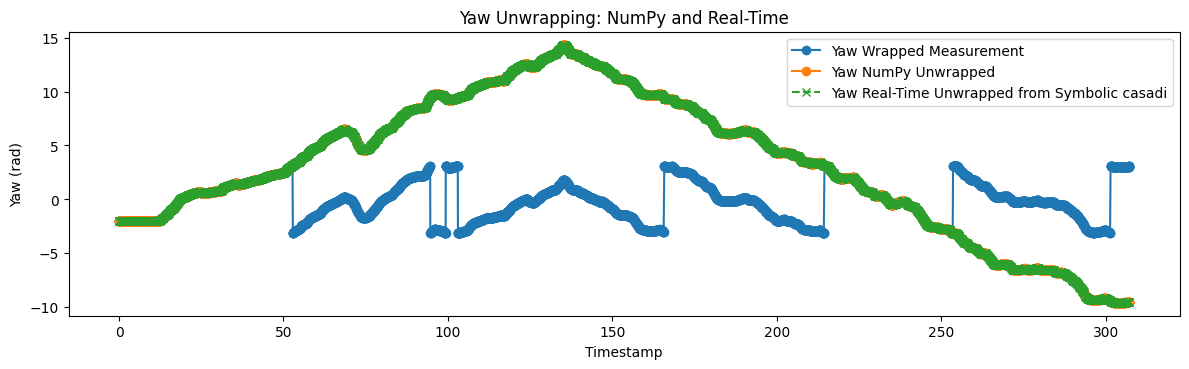

In [ ]:
plt.figure(figsize=(12, 10))

# Yaw Comparison
plt.subplot(3, 1, 3)
plt.plot(time, df['imu_yaw'], label='Yaw Wrapped Measurement from sensor', marker='o', linestyle='-')
plt.plot(time, imu_yaw_unwrapped_np, label='Yaw NumPy Unwrapped', marker='o', linestyle='-')
plt.plot(time, yaw_rt_unwrapped, label='Yaw Real-Time Unwrapped from Symbolic casadi', marker='x', linestyle='--')
plt.xlabel('Timestamp')
plt.ylabel('Yaw (rad)')
plt.title('Yaw Unwrapping: NumPy and Real-Time')
plt.legend()

plt.tight_layout()
plt.show()